### Loading in our Data

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


securities_df = pd.read_csv('spdr_etfs.csv')
securities_df['Date'] = pd.to_datetime(securities_df['Date'], dayfirst=False)
securities_df.set_index('Date', inplace=True)

securities_pct = securities_df.pct_change()
securities_pct.fillna(0, inplace=True)

### Setting the moving average period and creating a seperate DataFrame for the moving averages

In [57]:
ma_period = 50

securities_ma = securities_df.rolling(ma_period).mean()
securities_ma.dropna(axis=0, inplace=True)

### Adjusting the securities_df & securities_pct DataFrames so that we remove data prior to the moving average being calculated

In [58]:
securities_df, securities_pct = securities_df.loc[securities_ma.index[0]:], securities_pct.loc[securities_ma.index[0]:]

### Creating a new DataFrame that will store our position for each day for each security. Long=1, no position=0

In [59]:
dates = securities_pct.index
securities = securities_pct.columns

positions_pct = pd.DataFrame(data=None, columns=securities, index=dates)

for security in securities:

    # setting the value of long positions to 1. When the stock price > ma
    positions_pct.loc[securities_df[security].shift(1) > securities_ma[security], security] = 1

# setting the value of short/no position to 0
positions_pct.fillna(0, inplace=True)

### Creating a new DataFrame that will multiply the daily pct_change for each security by the position value on that day. Ultimately giving us the daily returns of the backtest

In [60]:
returns = pd.DataFrame(data=None, columns=securities, index=dates)

for security in securities:

    # the return column for each respective security is on a daily basis, position multiplied by daily return
    returns[security] = (positions_pct[security] * securities_pct[security])

In [61]:
returns.head()

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2010-03-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-03-17,0.005626,0.010955,0.012079,0.001624,0.003057,0.004313,0.003300,0.000311,0.004937
2010-03-18,-0.007067,-0.014900,-0.005653,0.006812,0.001306,0.001074,-0.004605,0.006843,-0.000307
2010-03-19,-0.013049,-0.015469,-0.008844,-0.007410,-0.009130,-0.007151,-0.009914,-0.003707,-0.004914
2010-03-22,0.014724,-0.002619,0.005099,0.002921,0.007459,0.005041,-0.006676,0.006512,0.010494


### Setting the $ value to run the backtest with. Also setting the frequency to rebalance the portfolio

In [62]:
invested = 1000

rebal_freq = 21

### Creating the DataFrames that will store the values for the backtest

In [63]:
# creating the DataFrame that will store the $ value of the total portfolio and setting initial value to invested
portfolio_value = pd.DataFrame(data=None, columns=['Portfolio'], index=dates)
portfolio_value.iloc[0]['Portfolio'] = invested

# pnl_stocks will hold the net PnL Data for each stock over the entire backtest
pnl_positions = pd.DataFrame(data=0, columns=securities, index=dates)

# the $ value allocated in each position
positions = pd.DataFrame(data=None, columns=securities, index=dates)

In [64]:
# main loop of the backtest
for t in range(0, len(dates), rebal_freq):

    num_stocks = len(securities)

    if t == 0:
        rb_day = dates[t]
    else:
        rb_day = dates[t + 1]

    # the day that we rebalance the portfolio, use this value in portfolio_value to calculate allocation
    rb_value = dates[t]

    try:
        rb_end = dates[t + rebal_freq]
    except IndexError:
        rb_end = dates[-1]

    for position in positions:
        positions.loc[rb_day: rb_end, position] = (portfolio_value['Portfolio'][rb_value] / num_stocks) * np.cumprod(1 + returns.loc[rb_day: rb_end, position])
        pnl_positions.loc[rb_day:rb_end, position] = (positions.loc[rb_day:rb_end, position] - portfolio_value['Portfolio'][rb_value] / num_stocks) + pnl_positions.loc[rb_value, position]

    portfolio_value.loc[rb_day: rb_end, 'Portfolio'] = np.nansum(positions.loc[rb_day: rb_end], axis=1)

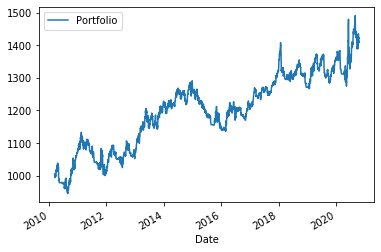

In [65]:
portfolio_value.plot()